In [7]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [9]:
dataset = MNIST(root='data', download=True)
test_dataset = MNIST(root='data/', train=False)

In [ ]:
import matplotlib.pyplot as plt

Label 6


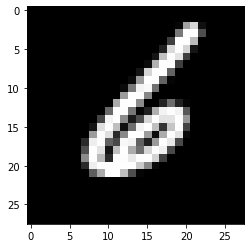

In [12]:
image, label = dataset[999]
plt.imshow(image, cmap='gray')
print('Label', label)

In [13]:
import torchvision.transforms as transforms

In [15]:
# transform the pictures (pixels) from dataset to tensor
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

img_tensor, label = dataset[999]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 6


In [16]:
from torch.utils.data import random_split

In [18]:
# training and validation datasets
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [19]:
from torch.utils.data import DataLoader

In [20]:
# dataloaders
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [21]:
import torch.nn as nn

In [25]:
# model
input_size = 28*28
num_classes = 10

# Logistic Regression model
model = nn.Linear(input_size, num_classes)
print(model.weight.shape, model.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [26]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out


In [28]:
model = MnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)

for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)

torch.Size([10, 784]) torch.Size([10])
outputs.shape :  torch.Size([128, 10])


In [29]:
import torch.nn.functional as F

In [35]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)
print("Probabilities of 1st row:\n", probs[0].data)
print("Sum: ", torch.sum(probs[0]).item())

Probabilities of 1st row:
 tensor([0.1365, 0.0753, 0.1004, 0.1171, 0.1169, 0.0723, 0.0988, 0.0815, 0.1157,
        0.0854])
Sum:  1.0


In [38]:
max_probs, preds = torch.max(probs, dim=1)
len(max_probs), len(preds)

(128, 128)

In [39]:
# Calculate accuracy of a model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
acc = accuracy(outputs, labels)
print('Accuracy of our model is {}%'.format(acc*100))

Accuracy of our model is 10.9375%


In [46]:
#loss function
loss_fn = F.cross_entropy

loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2967, grad_fn=<NllLossBackward>)


In [47]:
#training the model
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
#model = MnistModel()

In [48]:
# Evaluations
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
model = MnistModel()
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3418192863464355, 'val_acc': 0.04845727980136871}

In [50]:
history1 = fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9659, val_acc: 0.5943
Epoch [1], val_loss: 1.6933, val_acc: 0.7342
Epoch [2], val_loss: 1.4898, val_acc: 0.7691
Epoch [3], val_loss: 1.3361, val_acc: 0.7900
Epoch [4], val_loss: 1.2179, val_acc: 0.8015
Epoch [5], val_loss: 1.1249, val_acc: 0.8094
Epoch [6], val_loss: 1.0504, val_acc: 0.8161
Epoch [7], val_loss: 0.9894, val_acc: 0.8208
Epoch [8], val_loss: 0.9387, val_acc: 0.8259
Epoch [9], val_loss: 0.8960, val_acc: 0.8304
Epoch [10], val_loss: 0.8592, val_acc: 0.8337
Epoch [11], val_loss: 0.8274, val_acc: 0.8366
Epoch [12], val_loss: 0.7996, val_acc: 0.8399
Epoch [13], val_loss: 0.7751, val_acc: 0.8424
Epoch [14], val_loss: 0.7532, val_acc: 0.8449
Epoch [15], val_loss: 0.7336, val_acc: 0.8461
Epoch [16], val_loss: 0.7159, val_acc: 0.8491
Epoch [17], val_loss: 0.6998, val_acc: 0.8511
Epoch [18], val_loss: 0.6852, val_acc: 0.8522
Epoch [19], val_loss: 0.6718, val_acc: 0.8530


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

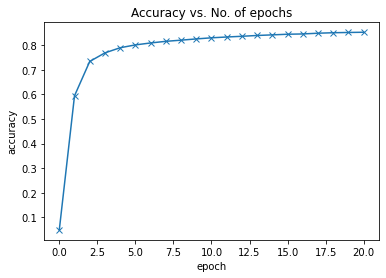

In [51]:
# Plot results
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')